In [67]:
# %load ../../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [2]:
data=loadmat('ex5data1.mat')

In [4]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Nov  4 22:27:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-15.93675813],
        [-29.15297922],
        [ 36.18954863],
        [ 37.49218733],
        [-48.05882945],
        [ -8.94145794],
        [ 15.30779289],
        [-34.70626581],
        [  1.38915437],
        [-44.38375985],
        [  7.01350208],
        [ 22.76274892]]),
 'y': array([[ 2.13431051],
        [ 1.17325668],
        [34.35910918],
        [36.83795516],
        [ 2.80896507],
        [ 2.12107248],
        [14.71026831],
        [ 2.61418439],
        [ 3.74017167],
        [ 3.73169131],
        [ 7.62765885],
        [22.7524283 ]]),
 'Xtest': array([[-33.31800399],
        [-37.91216403],
        [-51.20693795],
        [ -6.13259585],
        [ 21.26118327],
        [-40.31952949],
        [-14.54153167],
        [ 32.55976024],
        [ 13.39343255],
        [ 44.20988595],
        [ -1.14267768],
        [-

In [6]:
y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

yval = data['yval']
Xval = np.c_[np.ones_like(data['Xval']), data['Xval']]
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Xval:', Xval.shape)
print('yval:', yval.shape)

X_train: (12, 2)
y_train: (12, 1)
Xval: (21, 2)
yval: (21, 1)


Text(0, 0.5, 'y_train, Water flowing out of the dam(y)')

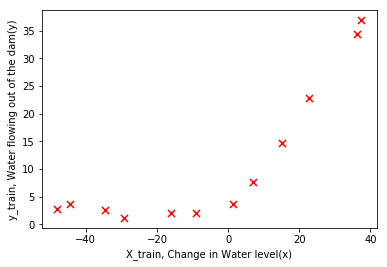

In [8]:
plt.scatter(X_train[:,1],y_train[:],s=50,c='r',marker='x',linewidths=1)
plt.xlabel('X_train, Change in Water level(x)')
plt.ylabel('y_train, Water flowing out of the dam(y)')

In [21]:
def linearRegCF(theta,X,y,reg):
    m=y.size
    h=X.dot(theta)
    J=(1/(2*m))*np.sum(np.square(h-y)) +(reg/2*m)*np.sum(np.square(theta[1,:]))
    return J

In [40]:
def linearRegCostFunction(theta, X, y, reg):
    m = y.size
    
    h = X.dot(theta)
    
    J = (1/(2*m))*np.sum(np.square(h-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
   
    return(J)

In [22]:
def Gradient(theta,X,y,reg):
    m=y.size
    h=X.dot(theta.reshape(-1,1))
    grad = (1/m)*(X.T.dot(h-y))+ (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    return(grad.flatten())

In [23]:
intial_theta=np.ones((X_train.shape[1],1))
cost=linearRegCF(intial_theta,X_train,y_train,0)
gradient=Gradient(intial_theta,X_train,y_train,0)
print(cost)
print(gradient)

303.9515255535976
[-15.30301567 598.16741084]


In [41]:
def trainLinearReg(X,y,reg):
    intial_theta=np.array([[15],[15]])
    res=minimize(linearRegCostFunction,intial_theta,args=(X,y,reg),method=None,jac=Gradient,options={'maxiter':5000})
    return (res)

In [42]:
fit=trainLinearReg(X_train,y_train,0)
fit

      fun: 1604.4002999186634
 hess_inv: array([[1.03142187, 0.00617881],
       [0.00617881, 0.001215  ]])
      jac: array([ 3.42437190e-12, -5.70370264e-10])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([13.08790351,  0.36777923])

In [43]:
regr=LinearRegression(fit_intercept=False)
regr.fit(X_train,y_train.ravel())
print(regr.coef_)
print(linearRegCostFunction(regr.coef_,X_train,y_train,0))

[13.08790351  0.36777923]
1604.4002999211034


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


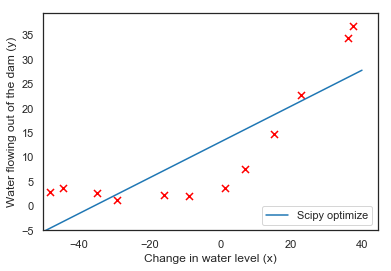

In [44]:
plt.plot(np.linspace(-50,40), (fit.x[0]+ (fit.x[1]*np.linspace(-50,40))), label='Scipy optimize')
#plt.plot(np.linspace(-50,40), (regr.coef_[0]+ (regr.coef_[1]*np.linspace(-50,40))), label='Scikit-learn')
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(ymin=-5)
plt.xlim(xmin=-50)
plt.legend(loc=4);

In [52]:
def learningCurve(X,y,Xval,yval,reg):
    m=y.size
    error_train=np.zeros((m,1))
    error_val=np.zeros((m,1))
    for i in np.arange(m):
        res=trainLinearReg(X[:i+1],y[:i+1],reg)
        error_train[i]=linearRegCostFunction(res.x,X[:i+1],y[:i+1],reg)
        error_val[i]=linearRegCostFunction(res.x,Xval,yval,reg)
    return (error_train,error_val)

In [53]:
t_error,v_error=learningCurve(X_train,y_train,Xval,yval,0)

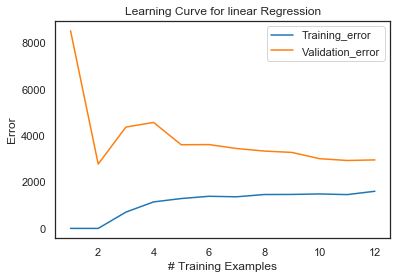

In [54]:
plt.plot(np.arange(1,13),t_error,label='Training_error')
plt.plot(np.arange(1,13),v_error,label='Validation_error')
plt.title('Learning Curve for linear Regression')
plt.xlabel('# Training Examples')
plt.ylabel('Error')
plt.legend()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.356626e-26
  overwrite_a=True).T


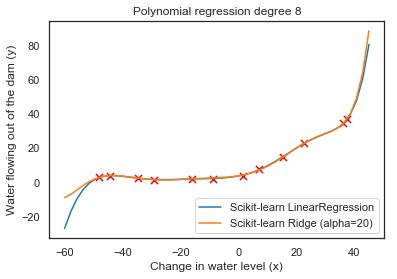

In [71]:
poly=PolynomialFeatures(degree=8)
X_train_poly=poly.fit_transform(X_train[:,1].reshape(-1,1))
regr2=LinearRegression()
regr2.fit(X_train_poly,y_train)

regr3=Ridge(alpha=20)
regr3.fit(X_train_poly,y_train)

#regr4=Lasso(alpha=1)
#regr4.fit(X_train_poly,y_train)

plot_x=np.linspace(-60,45)
plot_y = regr2.intercept_+ np.sum(regr2.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)
plot_y2 = regr3.intercept_ + np.sum(regr3.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)
#plot_y4=regr4.intercept+ np.sum(regr4.coef_*fit_transform(plot_x.reshape(-1,1)),axis=1)

plt.plot(plot_x, plot_y, label='Scikit-learn LinearRegression')
plt.plot(plot_x, plot_y2, label='Scikit-learn Ridge (alpha={})'.format(regr3.alpha))
#plt.plot(plot_x,plot_y4, label='Scikit-learn-Lasso (alpha={})'.format(regr4.alpha))
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial regression degree 8')
plt.legend(loc=4);